In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
file_path = "../../data/raw/MobiAct_combined.csv"

In [3]:
dtype_map = {
    "subject_id": "int16",
    "trial": "int16",
    "acc_x": "float32", "acc_y": "float32", "acc_z": "float32",
    "gyro_x": "float32","gyro_y": "float32","gyro_z": "float32",
    "azimuth": "float32",	"pitch": "float32",	"roll": "float32",
    "label": "category"
}

df = pd.read_csv(
    file_path,
    dtype=dtype_map,        # reduces memory footprint 
    engine='c')   

In [4]:
df

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,subject_id,trial
0,1295405261000,0.000000,-1.407311,9.614395,-2.086666,-0.844216,0.409280,0.086437,92.746895,-36.879684,-11.741077,STD,10,1
1,1295410262000,0.005001,-1.406354,9.612960,-2.084512,-0.711047,0.346971,0.076358,92.205360,-37.470173,-11.839779,STD,10,1
2,1295415352000,0.010091,-1.405380,9.611498,-2.082320,-0.598953,0.093462,0.025045,91.743050,-38.090790,-11.880902,STD,10,1
3,1295420307000,0.015046,-1.404432,9.610076,-2.080186,-0.128893,-0.012828,-0.002443,91.267319,-38.842915,-11.933741,STD,10,1
4,1295425257000,0.019996,-1.403484,9.608654,-2.078054,0.049480,0.018326,0.016493,90.819679,-39.538643,-11.957446,STD,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16756320,10354577784000,299.969995,-0.907934,13.533889,4.335380,1.207070,-6.215859,1.962099,218.442352,-56.026966,-33.223778,WAL,9,1
16756321,10354582775000,299.974986,-1.867024,12.331459,2.439285,0.968221,-6.103155,1.773953,220.688690,-57.077301,-31.897688,WAL,9,1
16756322,10354588060000,299.980271,-2.924407,11.485553,0.782717,0.740674,-6.034738,1.459663,222.816406,-58.044624,-30.614605,WAL,9,1
16756323,10354592749000,299.984960,-3.726923,11.084407,-0.258194,0.536645,-5.905845,1.027781,224.671646,-58.777103,-29.624798,WAL,9,1


In [5]:
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']
post_fall = ['LYI']

df['fall_label'] = df['label'].apply(
    lambda x: 'FALL' if x in fall_labels else ('POST_FALL' if x in post_fall else 'ADL')
)


In [6]:

import scipy.signal as signal
def apply_low_pass_filter(data, cutoff=3, fs=10, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    df_filtered = data.copy()
    for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
        df_filtered[col] = signal.filtfilt(b, a, data[col])
    return df_filtered



In [7]:

df = apply_low_pass_filter(df)


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth', 'pitch', 'roll']
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [9]:
from sklearn.model_selection import GroupShuffleSplit

# Get your subject group array
groups = df['subject_id'].values

# 1. Split off test subjects
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(gss1.split(df, df['label'], groups=groups))

trainval_subjects = df.iloc[trainval_idx]['subject_id'].unique()
test_subjects = df.iloc[test_idx]['subject_id'].unique()

df_trainval = df[df['subject_id'].isin(trainval_subjects)].copy()
df_test     = df[df['subject_id'].isin(test_subjects)].copy()

# 2. Split val subjects from trainval
groups_trainval = df_trainval['subject_id'].values
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(gss2.split(df_trainval, df_trainval['label'], groups=groups_trainval))

train_subjects = df_trainval.iloc[train_idx]['subject_id'].unique()
val_subjects   = df_trainval.iloc[val_idx]['subject_id'].unique()

df_train = df_trainval[df_trainval['subject_id'].isin(train_subjects)].copy()
df_val   = df_trainval[df_trainval['subject_id'].isin(val_subjects)].copy()

print("Train subjects:", set(train_subjects))
print("Val subjects:", set(val_subjects))
print("Test subjects:", set(test_subjects))


Train subjects: {np.int16(2), np.int16(3), np.int16(4), np.int16(7), np.int16(8), np.int16(11), np.int16(12), np.int16(14), np.int16(15), np.int16(16), np.int16(18), np.int16(20), np.int16(21), np.int16(22), np.int16(23), np.int16(25), np.int16(28), np.int16(30), np.int16(31), np.int16(32), np.int16(33), np.int16(34), np.int16(35), np.int16(36), np.int16(38), np.int16(39), np.int16(40), np.int16(42), np.int16(43), np.int16(44), np.int16(45), np.int16(47), np.int16(48), np.int16(49), np.int16(50), np.int16(51), np.int16(52), np.int16(54), np.int16(56), np.int16(57), np.int16(58), np.int16(61), np.int16(63), np.int16(64), np.int16(66), np.int16(67)}
Val subjects: {np.int16(59), np.int16(9), np.int16(19), np.int16(53), np.int16(55), np.int16(24), np.int16(27)}
Test subjects: {np.int16(1), np.int16(65), np.int16(37), np.int16(5), np.int16(6), np.int16(41), np.int16(10), np.int16(13), np.int16(46), np.int16(17), np.int16(26), np.int16(60), np.int16(29), np.int16(62)}


In [10]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

In [11]:
X_train = df_train[sensor_cols]
X_val = df_val[sensor_cols]
X_test = df_test[sensor_cols]

y_train = df_train['fall_label']
y_val= df_val['fall_label']
y_test = df_test['fall_label']

In [12]:
X_train

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll
5909,0.574711,0.688770,0.548061,0.498774,0.525496,0.505237,0.248811,0.498245,0.803802
5910,0.523214,0.733431,0.526113,0.485675,0.533352,0.505626,0.248992,0.497208,0.803323
5911,0.537714,0.719530,0.533186,0.489984,0.531495,0.505340,0.249246,0.496138,0.802555
5912,0.546412,0.710672,0.537789,0.492151,0.530783,0.505238,0.249492,0.495047,0.801762
5913,0.536848,0.718540,0.534089,0.488740,0.532785,0.505525,0.249750,0.493930,0.800865
...,...,...,...,...,...,...,...,...,...
16696321,0.522420,0.664807,0.608921,0.593540,0.471194,0.538274,0.751832,0.273277,0.492306
16696322,0.511482,0.668538,0.620656,0.588736,0.474768,0.541313,0.752327,0.272613,0.493788
16696323,0.520168,0.705243,0.658998,0.591700,0.473786,0.548820,0.752773,0.271993,0.495396
16696324,0.527464,0.761613,0.709697,0.594029,0.473765,0.555911,0.752935,0.271913,0.497041


In [13]:
y_train.value_counts()

fall_label
ADL          10279606
POST_FALL      711873
FALL           256837
Name: count, dtype: int64

In [14]:
y_val.value_counts()


fall_label
ADL          1735914
POST_FALL      95726
FALL           34540
Name: count, dtype: int64

### Segment into Windows

In [15]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth', 'pitch', 'roll']

from typing import Tuple, List

def sliding_multi_window(
    X: np.ndarray,
    y: np.ndarray,
    fs: int = 200,
    subwindow_duration: float = 0.2,
    overlap: float = 0.5,
    include_post_fall: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implements label-based main windows with fixed-size, overlapping sub-windows.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Time-series sensor data (e.g., acc_x, acc_y, ..., gyro_z).
    y : np.ndarray, shape (n_samples,)
        Frame-level labels: 'ADL', 'FALL', 'POST_FALL', etc.
    fs : int
        Sampling rate in Hz (e.g., 200).
    subwindow_duration : float
        Duration of each sub-window in seconds (e.g., 0.2).
    overlap : float
        Fractional overlap between sub-windows (0 to <1, e.g., 0.5 for 50%).
    include_post_fall : bool
        If True, emits 'POST_FALL' windows; if False, merges POST_FALL into 'FALL'.
    
    Returns
    -------
    X_sub : np.ndarray, shape (n_subwindows, window_size, n_features)
        Array of all extracted sub-windows.
    y_sub : np.ndarray, shape (n_subwindows,)
        Corresponding labels for each sub-window.
    """
    # Compute window parameters
    window_size = int(fs * subwindow_duration)
    step_size = int(window_size * (1 - overlap))
    if step_size < 1:
        raise ValueError("Overlap too large: step size <1 sample.")
    
    # Ensure proper indexing
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)
    
    X_sub, y_sub = [], []
    
    # Helper to slice sub-windows within a main segment
    def emit_windows(segment: np.ndarray, label: str):
        for start in range(0, len(segment) - window_size + 1, step_size):
            end = start + window_size
            X_sub.append(segment[start:end])
            y_sub.append(label)
    
    # Find contiguous main windows by label
    curr_label = y_arr[0]
    seg_start = 0
    for i in range(1, len(y_arr)):
        if y_arr[i] != curr_label:
            segment = X_arr[seg_start:i]
            if curr_label == "ADL":
                emit_windows(segment, "ADL")
            elif curr_label == "FALL":
                emit_windows(segment, "FALL")
            elif curr_label == "POST_FALL":
                if include_post_fall:
                    emit_windows(segment, "POST_FALL")
                else:
                    emit_windows(segment, "FALL")
            # start next main window
            seg_start = i
            curr_label = y_arr[i]
    
    # Handle the last main window
    segment = X_arr[seg_start:]
    if curr_label == "ADL":
        emit_windows(segment, "ADL")
    elif curr_label == "FALL":
        emit_windows(segment, "FALL")
    elif curr_label == "POST_FALL":
        if include_post_fall:
            emit_windows(segment, "POST_FALL")
        else:
            emit_windows(segment, "FALL")
    
    return np.stack(X_sub, axis=0), np.array(y_sub)


In [16]:
X_train_windows, y_train_windows = sliding_multi_window(X_train, y_train, fs =200,subwindow_duration=0.2, overlap=0.5,include_post_fall=False)
X_val_windows, y_val_windows = sliding_multi_window(X_val, y_val, fs =200,subwindow_duration=0.2, overlap=0.5,include_post_fall=False)
X_test_windows, y_test_windows = sliding_multi_window(X_test, y_test, fs =200,subwindow_duration=0.2, overlap=0.5,include_post_fall=False)

In [17]:
pd.DataFrame(y_train_windows).value_counts()

0   
ADL     513186
FALL     46857
Name: count, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_windows)
y_val_encoded = le.transform(y_val_windows)
y_test_encoded = le.transform(y_test_windows)


In [19]:
# Ensure they are NumPy arrays
y_train_encoded = np.array(y_train_encoded)
y_val_encoded = np.array(y_val_encoded)
y_test_encoded = np.array(y_test_encoded)

### Encode Label

In [20]:
X_train_windows.shape[1]

40

In [21]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class SparseCategoricalFocalLoss(Loss):
    def __init__(self, gamma=2., alpha=1., from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred)

        pt = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
        loss = -self.alpha * tf.pow(1. - pt, self.gamma) * tf.math.log(tf.clip_by_value(pt, 1e-8, 1.0))
        return tf.reduce_mean(loss)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Implementation of "LSTM-CNN Architecture for Human Activity Recognition" by Kun Xia et al. (IEEE Access, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/LSTM_CNN.py

## X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2]) 
num_classes = len(set(y_train_encoded))                  

model_lstm_conv = Sequential([

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(32, return_sequences=True, input_shape=input_shape),
    # second LSTM also returns full sequence
    LSTM(32, return_sequences=True),

    # ——— 1D‐Conv + Pool ———
    Conv1D(
        filters=64,
        kernel_size=3,
        strides=2,
        activation='relu',
        padding='valid'   # matches PyTorch default
    ),
    MaxPooling1D(pool_size=2, strides=2),

    # ——— second Conv block ———
    Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='valid'
    ),

    # ——— batch‐norm & spatial collapse ———
    BatchNormalization(),            # normalise over feature‐axis
    GlobalAveragePooling1D(),        # mean over time dimension

    # ——— classification head ———
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm_conv.compile(
    optimizer=Adam(1e-3),
    loss=SparseCategoricalFocalLoss(gamma=2., alpha=1.0),
    metrics=['accuracy']
)

model_lstm_conv.summary()

c:\Users\sovan\Desktop\Fall Detection\New ilab\ilab-group-12-1-fall-detection\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 32)         │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 19, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,378 (177.26 KB)

 Trainable params: 45,122 (176.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
from sklearn.utils import class_weight

In [24]:
# Compute class weights to handle imbalance
y_train_array = np.array(y_train_encoded)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = dict(enumerate(class_weights))


In [25]:
class_weights

{0: np.float64(0.5456530380797605), 1: np.float64(5.976086817337857)}

In [26]:
history = model_lstm_conv.fit(
    X_train_windows, y_train_encoded,
    validation_data=(X_val_windows, y_val_encoded),
    epochs=20,
    batch_size=64,
    class_weight=class_weights
)

Epoch 1/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 218s 24ms/step - accuracy: 0.9226 - loss: 0.0548 - val_accuracy: 0.9311 - val_loss: 0.0451
Epoch 2/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - accuracy: 0.9490 - loss: 0.0388 - val_accuracy: 0.9296 - val_loss: 0.0423
Epoch 3/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - accuracy: 0.9567 - loss: 0.0340 - val_accuracy: 0.9237 - val_loss: 0.0483
Epoch 4/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - accuracy: 0.9626 - loss: 0.0308 - val_accuracy: 0.9299 - val_loss: 0.0431
Epoch 5/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 214s 24ms/step - accuracy: 0.9667 - loss: 0.0284 - val_accuracy: 0.9225 - val_loss: 0.0487
Epoch 6/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 215s 25ms/step - accuracy: 0.9693 - loss: 0.0267 - val_accuracy: 0.9354 - val_loss: 0.0462
Epoch 7/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 218s 25ms/step - accuracy: 0.9705 - loss: 0.0255 - val_accuracy: 0.9311 - val_loss: 0.0584
Epoch 8/20
8751/8751 ━━━━━━━━━━━━━━━━━━━━ 219s 25ms/step - accuracy: 

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)


def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=False):
    # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    metrics_dict = dict(zip(metric_names, results))

    print("Evaluation Metrics:")
    for name, value in metrics_dict.items():
        print(f"{name.capitalize()}: {value:.4f}")

    # Predict class probabilities and take argmax for predicted class
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                    xticklabels=label_classes if label_classes else np.unique(y_test),
                    yticklabels=label_classes if label_classes else np.unique(y_test))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Classification report
    report = classification_report(y_test, y_pred, target_names=label_classes if label_classes else None)
    print("Classification Report:\n", report)

    # Macro-averaged metrics across all classes
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Macro Precision (sklearn): {:.4f}".format(precision))
    print("Macro Recall (sklearn): {:.4f}".format(recall))
    print("Macro F1 Score: {:.4f}".format(f1))

    # Update metrics dictionary to include sklearn metrics
    metrics_dict.update({
        'macro_precision': precision,
        'macro_recall': recall,
        'macro_f1_score': f1
    })

    return metrics_dict

Evaluation Metrics:
Loss: 0.0323
Compile_metrics: 0.9640
5669/5669 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step


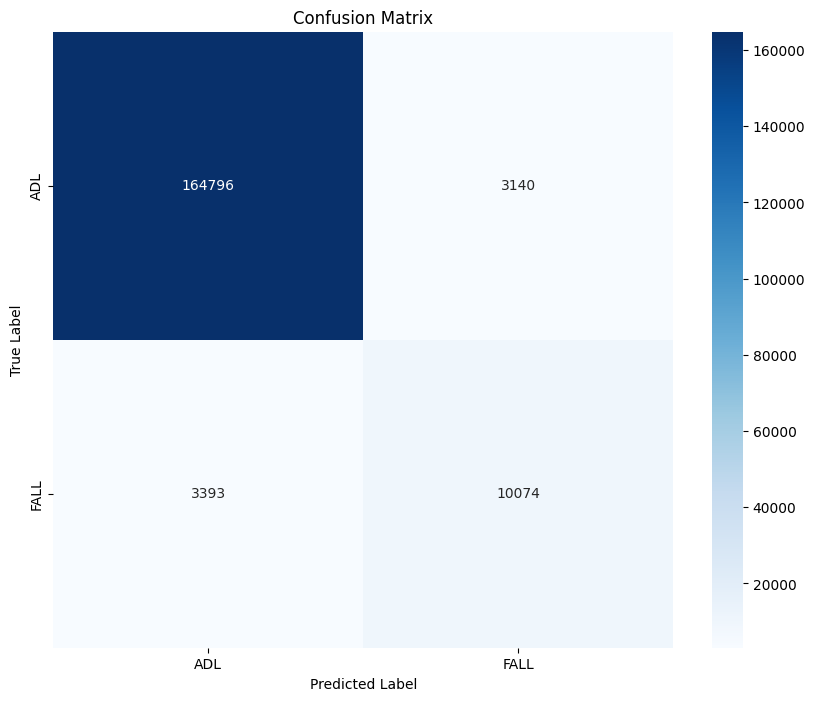

Classification Report:
               precision    recall  f1-score   support

         ADL       0.98      0.98      0.98    167936
        FALL       0.76      0.75      0.76     13467

    accuracy                           0.96    181403
   macro avg       0.87      0.86      0.87    181403
weighted avg       0.96      0.96      0.96    181403

Macro Precision (sklearn): 0.8711
Macro Recall (sklearn): 0.8647
Macro F1 Score: 0.8679


In [28]:
label_classes = le.classes_.tolist()
metrics = evaluate_model(model_lstm_conv, X_test_windows, y_test_encoded, label_classes=label_classes)


### 10-Fold Subject Cross Validation:

In [ ]:
import numpy as np
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import EarlyStopping

# assume X_windows, y_encoded, subject_ids are already defined:
# X_windows: (n_samples, timesteps, n_features)
# y_encoded: (n_samples,)
# subject_ids: array of shape (n_samples,) with each sample's subject_id

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_windows, y_encoded, groups=subject_ids), 1):
    print(f"\n=== Fold {fold}/{n_splits} ===")
    
    # split data
    X_train, X_val = X_windows[train_idx], X_windows[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # build a fresh model for each fold
    model = build_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_encoded)))
    
    # optional: early stopping on validation loss
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        shuffle=True,               # shuffle within the training set each epoch
        callbacks=[es],
        verbose=2
    )

    # evaluate
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f" → Val loss: {loss:.4f}, Val accuracy: {acc:.4f}")
    fold_metrics.append((loss, acc))

# summarise
losses, accs = zip(*fold_metrics)
print(f"\nAverage val accuracy over {n_splits} folds: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
